In [774]:
# Loading and installing the required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import shap
import re
import xgboost as xgb
from xgboost import XGBClassifier

In [775]:
# Load Dataset
data = pd.read_csv("filled_cybersecurity_data.csv")

# Preview Dataset
data.head()

,Unnamed: 0,Timestamp,Source.IP.Address,Destination.IP.Address,Source.Port,Destination.Port,Protocol,Packet.Length,Packet.Type,Traffic.Type,...,Action.Taken,Severity.Level,User.Information,Device.Information,Network.Segment,Geo.location.Data,Proxy.Information,Firewall.Logs,IDS.IPS.Alerts,Log.Source
0,1,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,No Alert Data,Server
1,2,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",No Proxy Info,Log Data,No Alert Data,Firewall
2,3,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,4,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",No Proxy Info,NaN,Alert Data,Firewall
4,5,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [776]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              40000 non-null  int64  
 1   Timestamp               40000 non-null  object 
 2   Source.IP.Address       40000 non-null  object 
 3   Destination.IP.Address  40000 non-null  object 
 4   Source.Port             40000 non-null  int64  
 5   Destination.Port        40000 non-null  int64  
 6   Protocol                40000 non-null  object 
 7   Packet.Length           40000 non-null  int64  
 8   Packet.Type             40000 non-null  object 
 9   Traffic.Type            40000 non-null  object 
 10  Payload.Data            40000 non-null  object 
 11  Malware.Indicators      40000 non-null  object 
 12  Anomaly.Scores          40000 non-null  float64
 13  Alerts.Warnings         40000 non-null  object 
 14  Attack.Type             40000 non-null

In [777]:
# Check for missing values
print(data.isnull().sum())

Unnamed: 0                    0
Timestamp                     0
Source.IP.Address             0
Destination.IP.Address        0
Source.Port                   0
Destination.Port              0
Protocol                      0
Packet.Length                 0
Packet.Type                   0
Traffic.Type                  0
Payload.Data                  0
Malware.Indicators            0
Anomaly.Scores                0
Alerts.Warnings               0
Attack.Type                   0
Attack.Signature              0
Action.Taken                  0
Severity.Level                0
User.Information              0
Device.Information            0
Network.Segment               0
Geo.location.Data             0
Proxy.Information             0
Firewall.Logs             19961
IDS.IPS.Alerts                0
Log.Source                    0
dtype: int64


In [778]:
# Device Information
data['Device.Information']

0        Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...
1        Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...
2        Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...
3        Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...
4        Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...
                               ...                        
39995    Mozilla/5.0 (iPad; CPU iPad OS 14_2_1 like Mac...
39996    Mozilla/5.0 (Windows; U; Windows 98; Win 9x 4....
39997    Mozilla/5.0 (Windows; U; Windows NT 4.0) Apple...
39998    Mozilla/5.0 (X11; Linux i686) AppleWebKit/536....
39999    Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...
Name: Device.Information, Length: 40000, dtype: object

Device Information has values that are very useful to us but it is confusing to read and hard to use when it is not indexed as it is.

In [779]:
# Function to extract OS, device type, and browser
def extract_user_agent_info(ua_string):
    # Extract the part within parentheses (OS and device type)
    os_device_match = re.search(r'\((.*?)\)', ua_string)
    os_device = os_device_match.group(1) if os_device_match else "Unknown"

    # Extract the browser details (after last space and before the version)
    browser_match = re.search(r'([A-Za-z]+)/\d+\.\d+', ua_string)
    browser = browser_match.group(1) if browser_match else "Unknown"

    return os_device, browser

In [780]:
# Add two new columns for os_device and browser
data.insert(0, "Os.Device", 0, allow_duplicates=True)
data.insert(0, "Browser", 0, allow_duplicates=True)


In [781]:

# Apply function
idx = 0
for ua in data['Device.Information']:
    os_device, browser = extract_user_agent_info(ua)
    data['Os.Device'][idx] = os_device
    data['Browser'][idx] = browser
    idx += 1

C:\Users\rocks\AppData\Local\Temp\ipykernel_12100\3123403730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Os.Device'][idx] = os_device
C:\Users\rocks\AppData\Local\Temp\ipykernel_12100\3123403730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Browser'][idx] = browser


In [782]:
# Checking to make sure the columns were added successfully
data.head()

# Dropping unneccessary columns
data = data.drop(columns=['Device.Information', 'Unnamed: 0'])

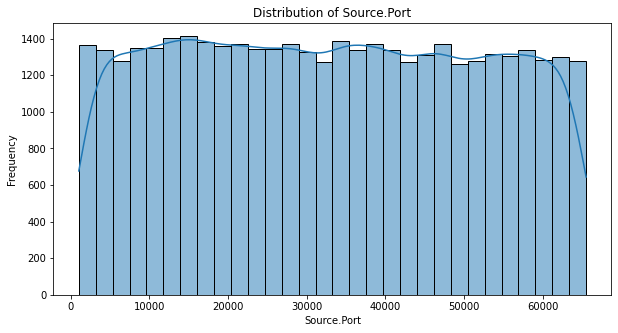

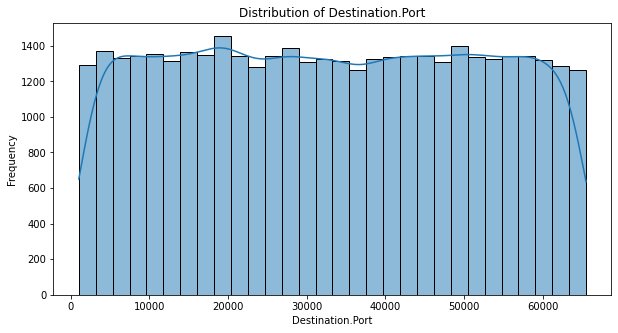

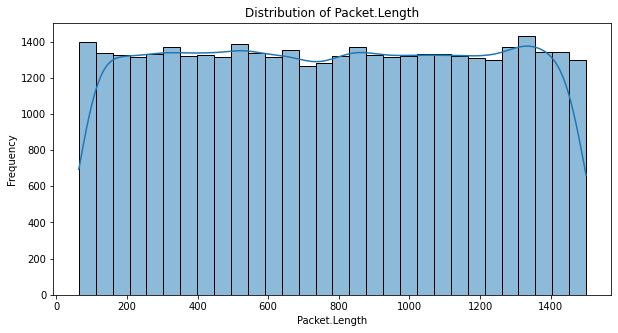

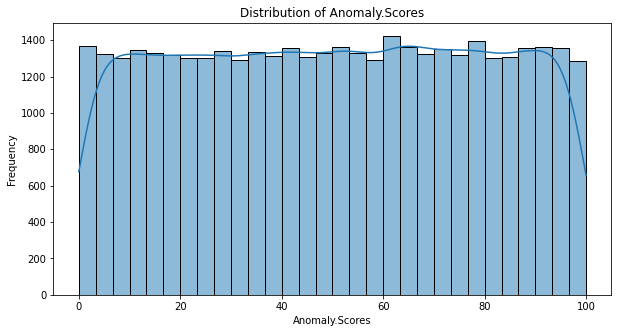

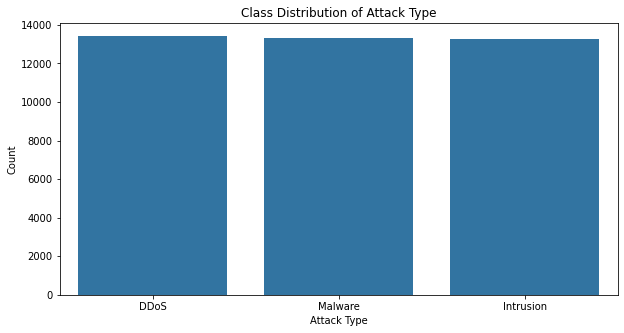

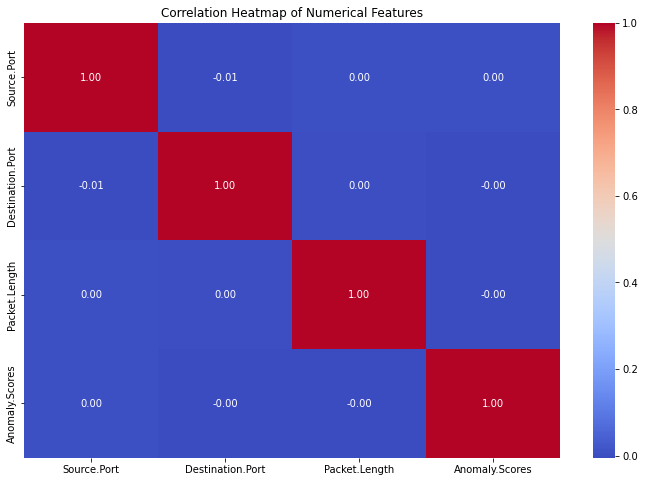

In [783]:
# EDA: Explore Distributions of Numerical Features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

# EDA: Class Distribution for Target Variable
plt.figure(figsize=(10, 5))
sns.countplot(x='Attack.Type', data=data, order=data['Attack.Type'].value_counts().index)
plt.title("Class Distribution of Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

# EDA: Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [784]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Browser                 40000 non-null  object 
 1   Os.Device               40000 non-null  object 
 2   Timestamp               40000 non-null  object 
 3   Source.IP.Address       40000 non-null  object 
 4   Destination.IP.Address  40000 non-null  object 
 5   Source.Port             40000 non-null  int64  
 6   Destination.Port        40000 non-null  int64  
 7   Protocol                40000 non-null  object 
 8   Packet.Length           40000 non-null  int64  
 9   Packet.Type             40000 non-null  object 
 10  Traffic.Type            40000 non-null  object 
 11  Payload.Data            40000 non-null  object 
 12  Malware.Indicators      40000 non-null  object 
 13  Anomaly.Scores          40000 non-null  float64
 14  Alerts.Warnings         40000 non-null

In [785]:
# Handle missing data
data = data.drop(columns=['Firewall.Logs'])

# Encode target variable 'Attack Type'
le = LabelEncoder()
data['Attack.Type'] = le.fit_transform(data['Attack.Type'])

# Drop high-cardinality features
data = data.drop(columns=['Source.IP.Address', 'Destination.IP.Address', 'Timestamp', 'Payload.Data'])

# Label encode remaining categorical features
categorical_features = data.select_dtypes(include=['object']).columns
for feature in categorical_features:
    data[feature] = le.fit_transform(data[feature])

# Separate features (X) and target (y)
X = data.drop(columns=['Attack.Type'])
y = data['Attack.Type']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [786]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Browser             40000 non-null  int32  
 1   Os.Device           40000 non-null  int32  
 2   Source.Port         40000 non-null  int64  
 3   Destination.Port    40000 non-null  int64  
 4   Protocol            40000 non-null  int32  
 5   Packet.Length       40000 non-null  int64  
 6   Packet.Type         40000 non-null  int32  
 7   Traffic.Type        40000 non-null  int32  
 8   Malware.Indicators  40000 non-null  int32  
 9   Anomaly.Scores      40000 non-null  float64
 10  Alerts.Warnings     40000 non-null  int32  
 11  Attack.Type         40000 non-null  int32  
 12  Attack.Signature    40000 non-null  int32  
 13  Action.Taken        40000 non-null  int32  
 14  Severity.Level      40000 non-null  int32  
 15  User.Information    40000 non-null  int32  
 16  Netw

In [787]:
# Balance classes by undersampling majority classes
train_data = pd.concat([X_train, y_train], axis=1)
class_count = train_data['Attack.Type'].value_counts()
min_class_size = class_count.min()

# Downsample majority classes
balanced_train_data = pd.concat(
    [resample(train_data[train_data['Attack.Type'] == cls],
              replace=False, # no replacement
              n_samples=min_class_size, # match minority class size
              random_state=42)
    for cls in class_count.index]
)

# Separate features and target after balancing
X_train_balanced = balanced_train_data.drop(columns=['Attack.Type'])
y_train_balanced = balanced_train_data['Attack.Type']

In [788]:
# Standardize Numerical Features
numerical_features = X_train_balanced.select_dtypes(include=['int64', 'int32', 'float64']).columns

scaler = StandardScaler()
X_train_balanced[numerical_features] = scaler.fit_transform(X_train_balanced[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [789]:
X_train.head()

,Browser,Os.Device,Source.Port,Destination.Port,Protocol,Packet.Length,Packet.Type,Traffic.Type,Malware.Indicators,Anomaly.Scores,Alerts.Warnings,Attack.Signature,Action.Taken,Severity.Level,User.Information,Network.Segment,Geo.location.Data,Proxy.Information,IDS.IPS.Alerts,Log.Source
34245,0,2933,32215,53447,2,673,0,2,1,62.34,1,0,2,1,23647,1,744,20148,0,0
8119,0,7548,65337,6151,2,157,1,1,0,75.17,1,1,2,2,2469,0,1755,9625,0,0
37921,0,495,5188,31282,2,520,0,2,0,48.72,1,0,1,1,1507,0,5245,20148,1,1
33187,0,1354,5690,20674,1,1193,0,2,1,32.36,0,0,2,0,16280,2,6318,20148,0,1
5490,1,9408,16646,25963,0,498,1,1,0,65.35,0,1,2,0,25219,1,2324,20148,0,1


In [790]:
# Validation After Preprocessing
print("Validation: Shape of Datasets")
print("Before Balancing:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("After Balancing:")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_balanced Distribution:")
print(y_train_balanced.value_counts())

print("Sample of Normalized Data:")
print(X_train_balanced.head())

Validation: Shape of Datasets
Before Balancing:
X_train: (32000, 20)
X_test: (8000, 20)
After Balancing:
X_train_balanced: (31836, 20)
y_train_balanced Distribution:
0    10612
2    10612
1    10612
Name: Attack.Type, dtype: int64
Sample of Normalized Data:
        Browser  Os.Device  Source.Port  Destination.Port  Protocol  \
36865 -0.501904  -1.390356    -0.793509          0.845456  0.009873   
38446 -0.501904   0.708323    -1.614191          1.630740  1.232921   
19110 -0.501904   0.733068     0.884311          1.260238 -1.213175   
32631 -0.501904  -2.096269     1.699176         -1.588020  0.009873   
20916 -0.501904   0.700966    -0.805410          1.448506 -1.213175   

       Packet.Length  Packet.Type  Traffic.Type  Malware.Indicators  \
36865      -1.576196    -0.988383     -1.226672            0.999435   
38446       1.056336    -0.988383      1.220983           -1.000566   
19110      -1.388502    -0.988383     -0.002845            0.999435   
32631      -0.772480    -0.9883

In [791]:
# Check for duplicates
print("Number of Duplicates:", X_train_balanced.duplicated().sum())

Number of Duplicates: 0


In [792]:
# Outlier detection

# Define the mean and standard deviation (should be these from standardized data)
data_mean = 0
data_std = 1

# Define the cutoff for outliers
cut_off = data_std * 3

# Identify outliers
lower_bound = data_mean - cut_off
upper_bound = data_mean + cut_off
outliers = (X_train_balanced < lower_bound) | (X_train_balanced > upper_bound)

# Outliers per column
num_outliers = outliers.sum().sum()
outliers_per_feature = outliers.sum()
print(f"Number of samples before outlier removal: {X_train_balanced.shape[0]}")
print(f"Number of outliers: {num_outliers}")
print(f"Number of outliers per feature: {outliers_per_feature}")

Number of samples before outlier removal: 31836
Number of outliers: 0
Number of outliers per feature: Browser               0
Os.Device             0
Source.Port           0
Destination.Port      0
Protocol              0
Packet.Length         0
Packet.Type           0
Traffic.Type          0
Malware.Indicators    0
Anomaly.Scores        0
Alerts.Warnings       0
Attack.Signature      0
Action.Taken          0
Severity.Level        0
User.Information      0
Network.Segment       0
Geo.location.Data     0
Proxy.Information     0
IDS.IPS.Alerts        0
Log.Source            0
dtype: int64


In [793]:
# Feature Selection Function

def select_features(X: np.ndarray, y: np.ndarray, num_features: int) -> tuple[np.ndarray, sklearn.feature_selection._univariate_selection.SelectKBest]:

  # Measure means between features and labels
  fs = SelectKBest(f_classif, k = num_features)
  fs.fit(X, y)
  X_fs = fs.transform(X)
  return X_fs, fs

ANOVA Scores:
Feature 1: 5.2251893229240896
Feature 2: 1.3356578549002678
Feature 3: 0.08022093861665101
Feature 4: 0.18665575637805765
Feature 5: 0.5209959542037007
Feature 6: 1.3012321502710071
Feature 7: 2.092711925873994
Feature 8: 0.25633319358536955
Feature 9: 0.16093637999897983
Feature 10: 0.2220947733676134
Feature 11: 2.0366432663176197
Feature 12: 0.43621360625309785
Feature 13: 1.1874092030757761
Feature 14: 0.5275194166555536
Feature 15: 0.9244499529291899
Feature 16: 0.8150713257667334
Feature 17: 1.4572580686044376
Feature 18: 1.266082780268029
Feature 19: 0.27601952485339915
Feature 20: 1.0261238031219235


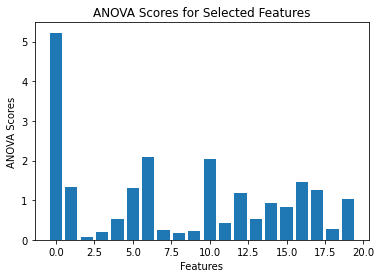

In [794]:
# Feature Selection

# Select Features
X_train_features, fs = select_features(X_train_balanced, y_train_balanced, 10)

# View ANOVA scores
print("ANOVA Scores:")
for i, score in enumerate(fs.scores_):
    print(f"Feature {i+1}: {score}")

# Plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel("Features")
plt.ylabel("ANOVA Scores")
plt.title("ANOVA Scores for Selected Features")
plt.show()

In [795]:
# Print the score and label for each feature

fs_scores = list(zip(fs.scores_, X_train_balanced.columns))
fs_scores.sort(key=lambda x: x[0], reverse=True)

for score, feature in fs_scores[:19]:
    print(f"Feature: {feature}, ANOVA Score: {score}")

Feature: Browser, ANOVA Score: 5.2251893229240896
Feature: Packet.Type, ANOVA Score: 2.092711925873994
Feature: Alerts.Warnings, ANOVA Score: 2.0366432663176197
Feature: Geo.location.Data, ANOVA Score: 1.4572580686044376
Feature: Os.Device, ANOVA Score: 1.3356578549002678
Feature: Packet.Length, ANOVA Score: 1.3012321502710071
Feature: Proxy.Information, ANOVA Score: 1.266082780268029
Feature: Action.Taken, ANOVA Score: 1.1874092030757761
Feature: Log.Source, ANOVA Score: 1.0261238031219235
Feature: User.Information, ANOVA Score: 0.9244499529291899
Feature: Network.Segment, ANOVA Score: 0.8150713257667334
Feature: Severity.Level, ANOVA Score: 0.5275194166555536
Feature: Protocol, ANOVA Score: 0.5209959542037007
Feature: Attack.Signature, ANOVA Score: 0.43621360625309785
Feature: IDS.IPS.Alerts, ANOVA Score: 0.27601952485339915
Feature: Traffic.Type, ANOVA Score: 0.25633319358536955
Feature: Anomaly.Scores, ANOVA Score: 0.2220947733676134
Feature: Destination.Port, ANOVA Score: 0.186655

We'll be using a ANOVA Score threshold of 0.8 for our modeling

In [796]:
# Dropping unneccessary features
X_train_balanced = X_train_balanced.drop(columns=['Severity.Level', 'Protocol', 'Attack.Signature', 'IDS.IPS.Alerts', 'Traffic.Type', 'Anomaly.Scores', 'Destination.Port' ,'Malware.Indicators'])
y_train_balanced = y_train_balanced.drop(columns=['Severity.Level', 'Protocol', 'Attack.Signature', 'IDS.IPS.Alerts', 'Traffic.Type', 'Anomaly.Scores', 'Destination.Port' ,'Malware.Indicators'])
X_test = X_test.drop(columns=['Severity.Level', 'Protocol', 'Attack.Signature', 'IDS.IPS.Alerts', 'Traffic.Type', 'Anomaly.Scores', 'Destination.Port' ,'Malware.Indicators'])

In [797]:
# XGBoost Model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_balanced, y_train_balanced)

y_predict = xgb_model.predict(X_test)

print('XGBoost - Train Accuracy:', xgb_model.score(X_train_balanced, y_train_balanced) * 100, '%')
print('XGBoost - Test Accuracy:', xgb_model.score(X_test, y_test) * 100, '%')

# Print performance metrics
print('\nClassification report:')
print(classification_report(y_test, y_predict))


XGBoost - Train Accuracy: 74.3215228043724 %
XGBoost - Test Accuracy: 33.3375 %

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.32      0.33      2686
           1       0.34      0.34      0.34      2653
           2       0.33      0.34      0.33      2661

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



In [798]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_balanced, y_train_balanced)

y_predict = rf_model.predict(X_test)

print('Random Forest - Train Accuracy:', rf_model.score(X_train_balanced, y_train_balanced) * 100, '%')
print('Random Forest - Test Accuracy:', rf_model.score(X_test, y_test) * 100, '%')

# Print performance metrics
print('\nClassification report:')
print(classification_report(y_test, y_predict))

Random Forest - Train Accuracy: 100.0 %
Random Forest - Test Accuracy: 32.0125 %

Classification report:
              precision    recall  f1-score   support

           0       0.32      0.33      0.32      2686
           1       0.33      0.34      0.33      2653
           2       0.31      0.29      0.30      2661

    accuracy                           0.32      8000
   macro avg       0.32      0.32      0.32      8000
weighted avg       0.32      0.32      0.32      8000

